In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import glob
import pprint
import copy
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from collections import OrderedDict

from dataset import *
from runner import ExptRunner
from runner import ExptEvaluator
from networks.imageencoder import *
from networks.imagedecoder import *
from networks.DenseAutoEncoder import DenseAutoEncoder
from networks.composedautoencoder import ComposedAutoEncoder
from networks.ConvVae import ConvVae
from networks.vae import VAE
from networks.dense import *
from networks.lossfunctions import *
from networks.reacherspecial import *
from helpers import *
import utils
import plottinghelpers
import simplereacherdimensions
import simplereacheradapters
from env.simulator import simulator, evaluator

In [3]:
import warnings
warnings.filterwarnings("ignore", category=torch.serialization.SourceChangeWarning)

In [4]:
opt = np.get_printoptions()
np.set_printoptions(threshold=np.inf)

In [5]:
torch.set_printoptions(sci_mode=False)

In [6]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [7]:
print (device)

cuda:2


In [8]:
# if torch.cuda.is_available():
#     print (torch.cuda.current_device())
#     torch.cuda.set_device(device)
#     print (torch.cuda.current_device())

In [9]:
img_res

64

In [10]:
root_folder = 'data/simple_reacher/ClearBG_ImageSize64'
# number_of_trajectories = 10
number_of_trajectories = 1000

In [11]:
# start = time.time()
# train_data = SimpleReacherOnDemandDataset(root_folder, range(4750), device=device)
# test_data = SimpleReacherOnDemandDataset(root_folder, range(4750, 5000), device=device)
# print ("Time Taken: {} sec".format(time.time() - start))

In [12]:
# Use reduced training data
start = time.time()
train_data = SimpleReacherOnDemandDataset(root_folder, range(900), device=device)
test_data = SimpleReacherOnDemandDataset(root_folder, range(900, 1000), device=device)
print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 3.2410948276519775 sec


In [13]:
print (len(train_data))
print (len(test_data))
print (train_data.trajectory_data.device)
print (test_data.trajectory_data.device)

19354
2224
cuda:2
cuda:2


In [14]:
def run_expts(train_epochs):
    for i in range(len(expts)):
        arg_lists = expts[i]
        cons_args = arg_lists[0]
        train_args = {}
        if (len(arg_lists)) > 1:
            train_args = arg_lists[1]
        test_args = {}
        if (len(arg_lists)) > 2:
            test_args = arg_lists[2]
        
        runner = ExptRunner(train_data=train_data, test_data=test_data, device=device, **cons_args)
        print ("Experiment logs folder: {}".format(runner.log_folder))
        with open(runner.log_folder + '/expt.txt', 'w') as f:
            f.write(pprint.pformat(arg_lists))
        runner.train(train_epochs, **train_args)

In [15]:
# First number represents the number of layers, second : channels per each layer, third : kernel size
img_auto_encoder_4_16_3 = lambda: ComposedAutoEncoder(x_dim=simplereacherdimensions.x_dim,
                                               img_res=simplereacherdimensions.img_res,
                                               layers_channels=[16, 16, 16, 16],
                                               useMaxPool=True,
                                               device=device)

img_auto_encoder_5_16_7 = lambda: ComposedAutoEncoder(x_dim=simplereacherdimensions.x_dim,
                                               img_res=simplereacherdimensions.img_res,
                                               layers_channels=[16, 16, 16, 16, 16],
                                               useMaxPool=True,
                                               device=device,
                                               kernel_size=7)

img_auto_encoder_5_32_7 = lambda: ComposedAutoEncoder(x_dim=simplereacherdimensions.x_dim,
                                               img_res=simplereacherdimensions.img_res,
                                               layers_channels=[32, 32, 32, 32, 32],
                                               useMaxPool=True,
                                               device=device,
                                               kernel_size=7)
img_auto_encoder_5_16_5 = lambda: ComposedAutoEncoder(x_dim=simplereacherdimensions.x_dim,
                                               img_res=simplereacherdimensions.img_res,
                                               layers_channels=[16, 16, 16, 16, 16],
                                               useMaxPool=True,
                                               device=device,
                                               kernel_size=5)

img_auto_encoder_5_32_5 = lambda: ComposedAutoEncoder(x_dim=simplereacherdimensions.x_dim,
                                               img_res=simplereacherdimensions.img_res,
                                               layers_channels=[32, 32, 32, 32, 32],
                                               useMaxPool=True,
                                               device=device,
                                               kernel_size=5)
img_encoder_4_16_3 = lambda: ImageEncoderFlatInput(img_res=simplereacherdimensions.img_res,
                                               input_channels=1,
                                               layers_channels=[16, 16, 16, 16],
                                               prefix='enc',
                                               useMaxPool=True,
                                               addFlatten=True,
                                               kernel_size=3)
img_encoder_5_32_5 = lambda: ImageEncoderFlatInput(img_res=simplereacherdimensions.img_res,
                                               input_channels=1,
                                               layers_channels=[32, 32, 32, 32, 32],
                                               prefix='enc',
                                               useMaxPool=True,
                                               addFlatten=True,
                                               kernel_size=5)
img_encoder_5_32_7 = lambda: ImageEncoderFlatInput(img_res=simplereacherdimensions.img_res,
                                               input_channels=1,
                                               layers_channels=[32, 32, 32, 32, 32],
                                               prefix='enc',
                                               useMaxPool=True,
                                               addFlatten=True,
                                               kernel_size=7)

In [16]:
def load_pretrained(folder):
    chkptFile = os.path.join('runs', folder, 'train_checkpoint.tar')
    return torch.load(chkptFile, map_location=device)['model']

def finetune_pretrained_end_to_end(net):
    c = copy.deepcopy(net)
    configure_net_training(c, True)
    return c

In [17]:
pretrain_image_auto_enc = load_pretrained('AutoEncoders/09-03/09-03-11-00-53-ImageAutoEncoder-Reacher-ComposedAutoEncoder4-L1')
pretrain_policy = load_pretrained('Policies/08-19/08-19-13-32-36-Policy-Reacher-Dense4WithTanh-L1')
# pretrain_img_to_env = load_pretrained('AutoEncoders/08-12/run1-img-to-env/08-12-18-44-36-ImageToEnv-Reacher-Conv4Dense3-MSE/')
pretrain_pol_augmented = load_pretrained('Policies/08-24/08-24-20-45-40-Policy_Augmented-Reacher-Dense4WithTanh-L1')
# pretrain_pol_trig = load_pretrained('Policies/08-25/run1-ld-policy/08-25-10-34-36-Policy_TrigAugmented-Reacher-Dense4WithTanh-L1')

In [18]:
img_layers = [16,16,16,16]
# z_dim = 4096 # 16 * 16 * 16 , This should be set based on above img_layers
# z_dim = 2048
z_dim = 256 # 16 * 4 * 4 , For 64 x 64 image
# z_dim = 1024 # 16 * 8 * 8 , For 128 x 128 image
# env_layers = [6, 512, z_dim]
env_layers = [6, 64, z_dim]
in_channels = 1
img_encoder = lambda: ImageEncoderFlatInput(in_channels, img_layers, 'imgenc', useMaxPool=True, addFlatten=True, img_res=simplereacheradapters.img_res)
# img_decoder = lambda: ImageDecoderFlatInput(z_dim, list(reversed(img_layers)), in_channels, 'imgdec', useSigmoid=True)
# env_encoder = lambda: Dense(env_layers, use_last_act=False, prefix='envenc')
env_decoder = lambda: Dense(list(reversed(env_layers)), last_act='sigmoid', prefix='envdec')
combined = lambda l1, l2: nn.Sequential(OrderedDict([
                              ('EncNet', l1()),
                              ('DecNet', l2()),
                            ]))

In [19]:
def env_enc_pretrained_img_dec():
    net = combined(env_encoder, img_decoder).to(device)
    load_mapped_state_dict(net, pretrain_imgEncDec, 'DecNet.net.imgdec', 'decoder.net.dec')
    return net

def pretrained_img_enc_env_dec(i_encoder, e_decoder):
    net = combined(i_encoder, e_decoder).to(device)
    load_mapped_state_dict(net, pretrain_image_auto_enc, 'EncNet.net.imgenc', 'encoder.net.enc')
    return net

def img_enc_env_dec_from_pretrained():
    net = combined(img_encoder, env_decoder).to(device)
    load_mapped_state_dict(net, pretrain_imgEncDec, 'EncNet.net.imgenc', 'encoder.net.enc')
    load_mapped_state_dict(net, pretrain_envEncDec, 'DecNet.net.envdec_fc0', 'decoder.dec_fc1') # Hacky
    return net

def latent_policy_from_latent(latentReference, policy=None, fix_indices=[0]):
    latent = copy.deepcopy(latentReference)
    if not policy:
        policy = Dense(layer_dims=[6, 16, 16, 3], last_act='tanh', prefix='pol')
    configure_net_training(latent, False)
    net = LatentPolicyNet(latent=latent, policy=policy).to(device)
    return net

def latent_policy_fixed_img_enc_pol_train_env_dec(policy=pretrain_policy, e_decoder=env_decoder, i_encoder=img_encoder):
    latent = pretrained_img_enc_env_dec(i_encoder, e_decoder)
    policy = copy.deepcopy(policy)
    configure_net_training(policy, False)
    configure_net_training(latent[0], False)
    return LatentPolicyNet(latent=latent, policy=policy).to(device)

def latent_policy_pretrained_img_enc_pol_train_end_to_end(policy=pretrain_policy, e_decoder=env_decoder, i_encoder=img_encoder):
    latent = pretrained_img_enc_env_dec(i_encoder, e_decoder)
    policy = copy.deepcopy(policy)
    return LatentPolicyNet(latent=latent, policy=policy).to(device)

def latentFilter_gt_x_latent_y(data, latent_output):
    return torch.cat((Xt_scaled_adapter(data), latent_output[:, 2:]), dim=1)

def image_to_env(conv, dense):
    return combined(conv, dense)

def LPGTX_fixed_img_enc_pol_train_env_dec(policy=pretrain_policy, e_decoder=env_decoder, i_encoder=img_encoder):
    latent = pretrained_img_enc_env_dec(i_encoder, e_decoder)
    policy = copy.deepcopy(policy)
    configure_net_training(policy, False)
    configure_net_training(latent[0], False)
    return LatentPolicyWithGroundTruthXNet(latent=latent, policy=policy).to(device)

def LPGTX_fixed_img_enc_pol_train_env_dec_end_to_end(policy=pretrain_policy, e_decoder=env_decoder, i_encoder=img_encoder):
    latent = pretrained_img_enc_env_dec(i_encoder, e_decoder)
    policy = copy.deepcopy(policy)
    return LatentPolicyWithGroundTruthXNet(latent=latent, policy=policy).to(device)

def LPGTX_Fresh(policy, e_decoder=env_decoder, i_encoder=img_encoder_4_16_3):
    latent = combined(i_encoder, e_decoder)
    return LatentPolicyWithGroundTruthXNet(latent=latent, policy=policy).to(device)

In [28]:
pretrain_policy

Dense(
  (net): Sequential(
    (pol_fc0): Linear(in_features=6, out_features=16, bias=True)
    (pol_relu0): ReLU()
    (pol_fc1): Linear(in_features=16, out_features=16, bias=True)
    (pol_relu1): ReLU()
    (pol_fc2): Linear(in_features=16, out_features=3, bias=True)
    (pol_tanh2): Tanh()
  )
)

In [19]:
# ItoU_Baseline_func = lambda: combined(img_encoder_4_16_3, lambda: Dense(layer_dims=[4096, 512, 3], last_act='tanh', prefix='pol'))
# ItoU_ours_untrained_func = lambda: LPGTX_Fresh(
#     policy = Dense(layer_dims=[6, 16, 16, 3], last_act='tanh', prefix='pol'),
#     e_decoder = lambda: Dense([4096, 512, 3], last_act='sigmoid', prefix='envdec'),
#     i_encoder=img_encoder_4_16_3
# )

In [20]:
ItoU_Baseline_func = lambda: combined(img_encoder_4_16_3, lambda: Dense(layer_dims=[256, 64, 3], last_act='tanh', prefix='pol'))
ItoU_ours_untrained_func = lambda: LPGTX_Fresh(
    policy = Dense(layer_dims=[6, 16, 16, 3], last_act='tanh', prefix='pol'),
    e_decoder = lambda: Dense([256, 64, 3], last_act='sigmoid', prefix='envdec'),
    i_encoder=img_encoder_4_16_3
)

In [20]:
# ItoU_Baseline_func = lambda: combined(img_encoder_4_16_3, lambda: Dense(layer_dims=[1024, 512, 3], last_act='tanh', prefix='pol'))
# ItoU_ours_untrained_func = lambda: LPGTX_Fresh(
#     policy = Dense(layer_dims=[6, 16, 16, 3], last_act='tanh', prefix='pol'),
#     e_decoder = lambda: Dense([1024, 512, 3], last_act='sigmoid', prefix='envdec'),
#     i_encoder=img_encoder_4_16_3
# )

In [21]:
expts = [
#   Image to Policy: Use pretrained image encoder, policy, train decoder/end-to-end 
#     [{
#         "expt_prefix":'Finetune_LowLR_FixImageEncoderTrigPolicy_TrainDecoder-Reacher-Conv5Dense4-L1',
#         "net_func": lambda: finetune_pretrained('Policies/08-19/08-19-20-24-49-FixImageEncoderPolicy_TrainDecoder-Reacher-Conv5Dense4-L1'),
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#         "optimizer_func": lambda net: optim.Adam(net.parameters(), lr=1e-4)
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'LPGTX_FixImageEncoderPolicy_TrainDecoderToY-Reacher-Conv4Dense3-L1',
#         "net_func": lambda: LPGTX_fixed_img_enc_pol_train_env_dec(
#             i_encoder=img_encoder_4_16_3,
#             e_decoder=lambda: Dense([4096, 512, 3], last_act='sigmoid', prefix='envdec'),
#             policy=pretrain_policy
#         ),
#         "data_adapter_func": simplereacheradapters.XtIt_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#     }],
#     [{
#         "expt_prefix":'LPGTX_FixImageEncoderAugmentedPolicy_TrainDecoderToY-Reacher-Conv4Dense3-L1',
#         "net_func": lambda: LPGTX_fixed_img_enc_pol_train_env_dec(
#             i_encoder=img_encoder_4_16_3,
#             e_decoder=lambda: Dense([4096, 512, 6], last_act='sigmoid', prefix='envdec'),
#             policy=pretrain_pol_augmented
#         ),
#         "data_adapter_func": simplereacheradapters.XtIt_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#     }],
#     [{
#         "expt_prefix":'LPGTX_FreshWithoutPreTraining_TrainEndToEnd-Reacher-Conv4Dense3-L1',
#         "net_func": ItoU_ours_untrained_func,
#         "data_adapter_func": simplereacheradapters.XtIt_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#     }],
#     [{
#         "expt_prefix":'LPGTX_FreshWithoutPreTraining_AugmentedPolicy_TrainEndToEnd-Reacher-Conv4Dense3-L1',
#         "net_func": lambda: LPGTX_Fresh(
#             policy = Dense(layer_dims=[9, 16, 16, 3], last_act='tanh', prefix='pol'),
#             e_decoder = lambda: Dense([4096, 512, 6], last_act='sigmoid', prefix='envdec'),
#             i_encoder=img_encoder_4_16_3
#         ),
#         "data_adapter_func": simplereacheradapters.XtIt_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#     }],
#     [{
#         "expt_prefix":'LPGTX_PretrainedImageEncoderPolicy_TrainEndToEnd-Reacher-Conv4Dense3-L1',
#         "net_func": lambda: LPGTX_fixed_img_enc_pol_train_env_dec_end_to_end(
#             i_encoder=img_encoder_4_16_3,
#             e_decoder=lambda: Dense([4096, 512, 3], last_act='sigmoid', prefix='envdec'),
#             policy=pretrain_policy
#         ),
#         "data_adapter_func": simplereacheradapters.XtIt_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#     }],
#     [{
#         "expt_prefix":'LPGTX_PretrainedImageEncoderAugmentedPolicy_TrainEndToEnd-Reacher-Conv4Dense3-L1',
#         "net_func": lambda: LPGTX_fixed_img_enc_pol_train_env_dec_end_to_end(
#             i_encoder=img_encoder_4_16_3,
#             e_decoder=lambda: Dense([4096, 512, 6], last_act='sigmoid', prefix='envdec'),
#             policy=pretrain_pol_augmented
#         ),
#         "data_adapter_func": simplereacheradapters.XtIt_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#     }],
#     [{
#         "expt_prefix":'LPGTX_RegularPolicyFinetuneEndToEnd_AfterDecoder_LowLR-Reacher-Conv4Dense3-L1',
#         "net_func": lambda: finetune_pretrained_end_to_end(
#             load_pretrained('Policies/09-09/run2_100_epochs/09-09-21-22-50-LPGTX_FixImageEncoderPolicy_TrainDecoderToY-Reacher-Conv4Dense3-L1')
#         ),
#         "data_adapter_func": simplereacheradapters.XtIt_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "optimizer_func": lambda net: optim.Adam(net.parameters(), lr=1e-4)
#     }],
#     [{
#         "expt_prefix":'LPGTX_AugmentedPolicyFinetuneEndToEnd_AfterDecoder_LowLR-Reacher-Conv4Dense3-L1',
#         "net_func": lambda: finetune_pretrained_end_to_end(
#             load_pretrained('Policies/09-28/run2-decoder-100-epochs/09-28-21-38-10-LPGTX_FixImageEncoderAugmentedPolicy_TrainDecoderToY-Reacher-Conv4Dense3-L1')
#         ),
#         "data_adapter_func": simplereacheradapters.XtIt_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "optimizer_func": lambda net: optim.Adam(net.parameters(), lr=1e-4)
#     }],
#     [{
#         "expt_prefix":'LPGTX_RegularPolicyFinetuneEndToEnd_AfterDecoder_RegularLR-Reacher-Conv4Dense3-L1',
#         "net_func": lambda: finetune_pretrained_end_to_end(
#             load_pretrained('Policies/09-09/run2_100_epochs/09-09-21-22-50-LPGTX_FixImageEncoderPolicy_TrainDecoderToY-Reacher-Conv4Dense3-L1')
#         ),
#         "data_adapter_func": simplereacheradapters.XtIt_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#     }],
#     [{
#         "expt_prefix":'LPGTX_AugmentedPolicyFinetuneEndToEnd_AfterDecoder_RegularLR-Reacher-Conv4Dense3-L1',
#         "net_func": lambda: finetune_pretrained_end_to_end(
#             load_pretrained('Policies/09-09/run2_100_epochs/09-10-01-03-19-LPGTX_FixImageEncoderAugmentedPolicy_TrainDecoderToY-Reacher-Conv4Dense3-L1')
#         ),
#         "data_adapter_func": simplereacheradapters.XtIt_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#     }],
#   Train policy using fixed Image To Env function
#     [{
#         "expt_prefix":'FixImageToEnv_TrainFreshPolicy-Reacher-Conv4Dense3-MSE',
#         "net_func": lambda: latent_policy_from_latent(pretrain_img_to_env),
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": mse_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#   Image To Env function
#     [{
#         "expt_prefix":'ImageToEnv-Reacher-Conv4Dense3-MSE',
#         "net_func": lambda: image_to_env(img_encoder, env_decoder),
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.XtYt_scaled_adapter,
#         "loss_adapter_func": mse_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#   Policy (Low-dimensional)
#     [{
#         "expt_prefix":'TrainOn500-Policy-Reacher-Dense4WithTanh-L1',
#         "net_func": lambda: Dense(layer_dims=[6, 16, 16, 3], last_act='tanh', prefix='pol'),
#         "data_adapter_func": simplereacheradapters.XtYt_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#   Image to policy : Direct
    [{
        "expt_prefix":'ClearBGImageSize64_ImageToPolicy-Reacher-Conv4Dense3-L1',
        "net_func": ItoU_Baseline_func, 
        "data_adapter_func": simplereacheradapters.It_scaled_adapter,
        "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
        "loss_adapter_func": l1_loss_adapter,
     },
    {
    },
    {
        "loss_adapter": l1_loss_adapter
    }],
#   Image autoencoder
#     [{
#         "expt_prefix":'ImageAutoEncoder-Reacher-ComposedAutoEncoder4-L1',
#         "net_func": img_auto_encoder_4_16_3,
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
]

In [22]:
train_epochs = 50
run_expts(train_epochs)

Experiment logs folder: runs/11-04-12-57-12-ClearBGImageSize64_ImageToPolicy-Reacher-Conv4Dense3-L1


In [23]:
start = time.time()

for chkpt_file in utils.enumerate_files(rootdir='runs/11-04-12-57-12-ClearBGImageSize64_ImageToPolicy-Reacher-Conv4Dense3-L1'):
    e = ExptEvaluator(chkpt_file, train_data, test_data, device)
    e.test()
    print ('Done with checkpoint file {}'.format(chkpt_file))

print ("Time Taken: {} sec".format(time.time() - start))

Done with checkpoint file runs/11-04-12-57-12-ClearBGImageSize64_ImageToPolicy-Reacher-Conv4Dense3-L1/train_checkpoint.tar
Time Taken: 8.238825559616089 sec


In [51]:
plottinghelpers.save_all_plots_img_auto_encoder_run(rootdir='runs/09-03-11-00-53-ImageAutoEncoder-Reacher-ComposedAutoEncoder4-L1')

Processing folder : runs/09-03-11-00-53-ImageAutoEncoder-Reacher-ComposedAutoEncoder4-L1
Done


In [50]:
start = time.time()

plottinghelpers.generate_img_reconstructions(
    rootdir='runs/09-03-11-00-53-ImageAutoEncoder-Reacher-ComposedAutoEncoder4-L1',
    device=device, train_data=train_data, test_data=test_data,
    img_res=simplereacherdimensions.img_res)

print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 1.5567817687988281 sec


In [24]:
cpu = torch.device('cpu')
cpu

device(type='cpu')

In [25]:
root_folder

'data/simple_reacher/ClearBG_ImageSize64'

In [26]:
start = time.time()
train_traj_data = SimpleReacherTrajectoryDataset(root_folder, range(100), device=cpu) #only a subset of training_data
test_traj_data = SimpleReacherTrajectoryDataset(root_folder, range(900, 1000), device=cpu)
print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 0.00011754035949707031 sec


In [58]:
pretrained_net = nn.Sequential(OrderedDict([
                      ('ItoY', pretrain_img_to_env),
                      ('pol', pretrain_policy),
                    ])).to(cpu)
pretrained_net = pretrained_net.eval()

In [32]:
start = time.time()

for chkpt_file in utils.enumerate_files(rootdir='runs/Policies/11-02/11-04-12-57-12-ClearBGImageSize64_ImageToPolicy-Reacher-Conv4Dense3-L1'):
    print ('Start processing checkpoint file {}'.format(chkpt_file))
    is_image_based_policy=True # DO NOT FORGET TO SET THESE TWO
    policy_takes_robot_state=False
    img_transform = None
    # img_transform = lambda arr:np.where(np.bitwise_or(arr < 125, arr > 129), arr, np.zeros_like(arr)) #uncomment this for usual runs.
    e = evaluator(chkpt_file, cpu, is_image_based_policy=is_image_based_policy, persist_to_disk=True, 
                  op_reverse_adapter=simplereacheradapters.Ut_scaled_adapter_zero_center_reverse,
                  ip_adapter=simplereacheradapters.It_scaled_adapter_eval,
                  policy_takes_robot_state=policy_takes_robot_state,
                  img_transform=img_transform
                 )
    e.evaluate(test_traj_data, target_folder='TestSet_Evaluations', save_all_to_disk=False)
    # e.evaluate(train_traj_data, target_folder='SmallTrainSet_Evaluations')
    print ('')

print ("Time Taken: {} sec".format(time.time() - start))

Start processing checkpoint file runs/Policies/11-02/11-04-12-57-12-ClearBGImageSize64_ImageToPolicy-Reacher-Conv4Dense3-L1/train_checkpoint.tar
-------------------------------------------------------------
runs/Policies/11-02/11-04-12-57-12-ClearBGImageSize64_ImageToPolicy-Reacher-Conv4Dense3-L1
-------------------------------------------------------------
Number of Trajectories Ended up Within Goal Region (Goal Loss <= 0.10000000149011612): 17.0
Average Policy L1 Loss: 0.025661155581474304
Average Trajectory Loss: 0.14934462308883667
Average Goal Loss: 0.3889787793159485
Average Combined State Loss: 0.07670298963785172

Least Policy L1 Error: Index = 71, Value = 0.012134619988501072
Least Trajectory Error: Index = 54, Value = 0.02816729061305523
Least Goal Error: Index = 68, Value = 0.014949720352888107

Highest Policy L1 Error: Index = 90, Value = 0.07863682508468628
Highest Trajectory Error: Index = 93, Value = 0.6920504570007324
Highest Goal Error: Index = 93, Value = 1.4298119544

In [28]:
start = time.time()

for chkpt_file in utils.enumerate_files(rootdir='runs/Policies/11-02'):
    print (chkpt_file)
    folder = os.path.join(os.path.dirname(chkpt_file), 'TestSet_Evaluations')
    if os.path.exists(folder):
        print ('Deleting folder : {}'.format(folder))
        shutil.rmtree(folder, ignore_errors=True)
#     os.rename(chkpt_file, chkpt_file+'.bkp')

print ("Time Taken: {} sec".format(time.time() - start))

runs/Policies/09-10/run1-10-epochs/09-10-10-40-06-LPGTX_PretrainedImageEncoderPolicy_TrainEndToEnd-Reacher-Conv4Dense3-L1/train_checkpoint.tar
Deleting folder : runs/Policies/09-10/run1-10-epochs/09-10-10-40-06-LPGTX_PretrainedImageEncoderPolicy_TrainEndToEnd-Reacher-Conv4Dense3-L1/SmallTrainSet_Evaluations
runs/Policies/09-10/run1-10-epochs/09-10-11-37-11-LPGTX_PretrainedImageEncoderAugmentedPolicy_TrainEndToEnd-Reacher-Conv4Dense3-L1/train_checkpoint.tar
Deleting folder : runs/Policies/09-10/run1-10-epochs/09-10-11-37-11-LPGTX_PretrainedImageEncoderAugmentedPolicy_TrainEndToEnd-Reacher-Conv4Dense3-L1/SmallTrainSet_Evaluations
runs/Policies/09-10/run1-10-epochs/09-10-12-32-12-LPGTX_RegularPolicyFinetuneEndToEnd_AfterDecoder_LowLR-Reacher-Conv4Dense3-L1/train_checkpoint.tar
Deleting folder : runs/Policies/09-10/run1-10-epochs/09-10-12-32-12-LPGTX_RegularPolicyFinetuneEndToEnd_AfterDecoder_LowLR-Reacher-Conv4Dense3-L1/SmallTrainSet_Evaluations
runs/Policies/09-10/run1-10-epochs/09-10-13

In [33]:
plottinghelpers.save_all_plots_policy_rollout_run(rootdir='runs/Policies/11-02/11-04-12-57-12-ClearBGImageSize64_ImageToPolicy-Reacher-Conv4Dense3-L1')

Processing folder : runs/Policies/11-02/11-04-12-57-12-ClearBGImageSize64_ImageToPolicy-Reacher-Conv4Dense3-L1
Done


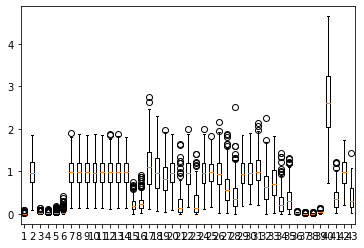

From left to right:
08-19-13-32-36-Policy-Reacher-Dense4WithTanh-L1
08-19-20-24-49-FixImageEncoderPolicy_TrainDecoder-Reacher-Conv5Dense4-L1
08-21-19-09-09-Policy-Reacher-Dense4WithTanh-L1
08-22-10-38-38-Policy-Reacher-Dense4WithTanh-L1
08-24-20-45-40-Policy_Augmented-Reacher-Dense4WithTanh-L1
08-25-10-34-36-Policy_TrigAugmented-Reacher-Dense4WithTanh-L1
08-25-14-03-35-FixImageEncoderAugmentedPolicy_TrainDecoder-Reacher-Conv5Dense4-L1
08-25-20-26-27-FixImageEncoderTrigPolicy_TrainDecoder-Reacher-Conv5Dense4-L1
08-31-16-35-49-Finetune_LowLR_FixImageEncoderTrigPolicy_TrainDecoder-Reacher-Conv5Dense4-L1
08-31-21-05-50-Finetune_RegularLR_FixImageEncoderTrigPolicy_TrainDecoder-Reacher-Conv5Dense4-L1
09-01-13-50-28-ImageToPolicy-Reacher-ComposedAutoEncoder5Dense-L1
09-01-20-46-16-Train_ImageEncoderAndPolicy_EndToEnd-Reacher-Conv5Dense4-L1
09-01-21-40-35-Train_ImageEncoderAndAugmentedPolicy_EndToEnd-Reacher-Conv5Dense4-L1
09-01-22-34-02-Train_ImageEncoderAndTrigPolicy_EndToEnd-Reacher-Conv5De

In [34]:
plottinghelpers.box_plot_across_runs(
    rootdir='runs/Policies',
    eval_folder_name='TestSet_Evaluations',
    error_index=4,
    metric_name='Goal Deviation'
)

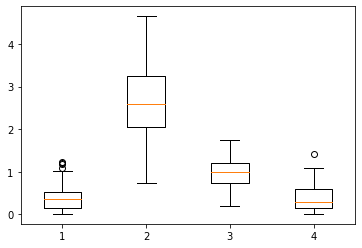

From left to right:
11-02-16-25-33-ImageSize64_ImageToPolicy-Reacher-Conv4Dense3-L1
11-02-15-49-18-ImageSize64ClearBG_ImageToPolicy-Reacher-Conv4Dense3-L1
11-02-17-10-37-ImageSize128_ImageToPolicy-Reacher-Conv4Dense3-L1
11-04-12-57-12-ClearBGImageSize64_ImageToPolicy-Reacher-Conv4Dense3-L1


In [35]:
plottinghelpers.box_plot_across_runs(
    rootdir='runs/Policies/',
    eval_folder_name='TestSet_Evaluations',
    error_index=4,
    metric_name='Goal Deviation',
    include=[
        '11-02-16-25-33-ImageSize64_ImageToPolicy-Reacher-Conv4Dense3-L1',
        '11-02-15-49-18-ImageSize64ClearBG_ImageToPolicy-Reacher-Conv4Dense3-L1',
        '11-02-17-10-37-ImageSize128_ImageToPolicy-Reacher-Conv4Dense3-L1',
        '11-04-12-57-12-ClearBGImageSize64_ImageToPolicy-Reacher-Conv4Dense3-L1'
    ]
)

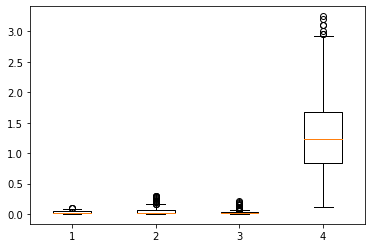

From left to right:
08-11-15-10-38-Policy-Reacher-Dense4WithTanh-L1
08-11-15-45-41-Policy-Reacher-Dense4WithTanh-mse
08-17-11-09-51-Policy-Reacher-Dense4WithTanh-mse
08-17-14-49-24-Policy-Reacher-Dense4WithSigmoid-L1


In [26]:
plottinghelpers.box_plot_across_runs(
    rootdir='runs/Policies',
    eval_folder_name='TestSet_Evaluations',
    error_index=4,
    metric_name='Goal Deviation',
    include=[
        '08-11-15-10-38-Policy-Reacher-Dense4WithTanh-L1',
        '08-11-15-45-41-Policy-Reacher-Dense4WithTanh-mse',
        '08-17-11-09-51-Policy-Reacher-Dense4WithTanh-mse',
        '08-17-14-49-24-Policy-Reacher-Dense4WithSigmoid-L1'
    ]
)

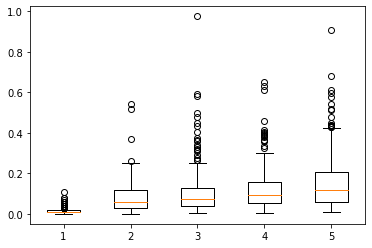

From left to right:
08-19-13-32-36-Policy-Reacher-Dense4WithTanh-L1
09-02-10-06-01-ImageToPolicy-Reacher-ImageEncoder4_16_3Dense3-L1
09-03-17-12-26-Train_PretrainedImageEncoderAndPolicy_EndToEnd-Reacher-Conv4Dense3-L1
09-10-11-37-11-LPGTX_PretrainedImageEncoderAugmentedPolicy_TrainEndToEnd-Reacher-Conv4Dense3-L1
09-10-13-25-59-LPGTX_AugmentedPolicyFinetuneEndToEnd_AfterDecoder_LowLR-Reacher-Conv4Dense3-L1


In [12]:
plottinghelpers.box_plot_across_runs(
    rootdir='runs/Policies',
    eval_folder_name='TestSet_Evaluations',
    error_index=4,
    metric_name='Goal Deviation',
    include=[
        '08-19-13-32-36-Policy-Reacher-Dense4WithTanh-L1',
        '09-02-10-06-01-ImageToPolicy-Reacher-ImageEncoder4_16_3Dense3-L1',
        '09-03-17-12-26-Train_PretrainedImageEncoderAndPolicy_EndToEnd-Reacher-Conv4Dense3-L1',
        '09-10-11-37-11-LPGTX_PretrainedImageEncoderAugmentedPolicy_TrainEndToEnd-Reacher-Conv4Dense3-L1',
        '09-10-13-25-59-LPGTX_AugmentedPolicyFinetuneEndToEnd_AfterDecoder_LowLR-Reacher-Conv4Dense3-L1'
    ]
)

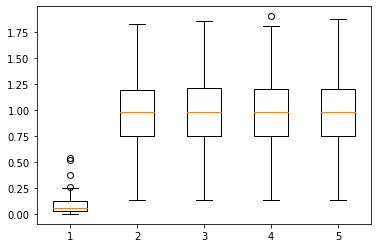

From left to right:
09-02-10-06-01-ImageToPolicy-Reacher-ImageEncoder4_16_3Dense3-L1
08-14-08-54-19-FixImageEncoderPolicy_TrainDecoder-Reacher-Conv5Dense3-MSE
08-19-20-24-49-FixImageEncoderPolicy_TrainDecoder-Reacher-Conv5Dense4-L1
08-25-14-03-35-FixImageEncoderAugmentedPolicy_TrainDecoder-Reacher-Conv5Dense4-L1
08-25-20-26-27-FixImageEncoderTrigPolicy_TrainDecoder-Reacher-Conv5Dense4-L1


In [30]:
plottinghelpers.box_plot_across_runs(
    rootdir='runs/Policies',
    eval_folder_name='TestSet_Evaluations',
    error_index=4,
    metric_name='Goal Deviation',
    include=[
        '09-02-10-06-01-ImageToPolicy-Reacher-ImageEncoder4_16_3Dense3-L1',
        '08-19-20-24-49-FixImageEncoderPolicy_TrainDecoder-Reacher-Conv5Dense4-L1',
        '08-25-14-03-35-FixImageEncoderAugmentedPolicy_TrainDecoder-Reacher-Conv5Dense4-L1',
        '08-25-20-26-27-FixImageEncoderTrigPolicy_TrainDecoder-Reacher-Conv5Dense4-L1'
    ]
)

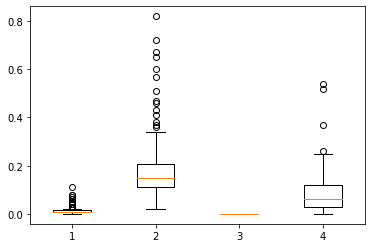

From left to right:
08-19-13-32-36-Policy-Reacher-Dense4WithTanh-L1
08-13-11-15-00-FixImageToEnv_TrainFreshPolicy-Reacher-Conv4Dense3-MSE

09-02-10-06-01-ImageToPolicy-Reacher-ImageEncoder4_16_3Dense3-L1


In [31]:
plottinghelpers.box_plot_across_runs(
    rootdir='runs/Policies',
    eval_folder_name='TestSet_Evaluations',
    error_index=4,
    metric_name='Goal Deviation',
    include=[
        '08-19-13-32-36-Policy-Reacher-Dense4WithTanh-L1',
        '08-13-11-15-00-FixImageToEnv_TrainFreshPolicy-Reacher-Conv4Dense3-MSE',
        '08-14-08-54-19-FixImageEncoderPolicy_TrainDecoder-Reacher-Conv4Dense3-MSE',
        '09-02-10-06-01-ImageToPolicy-Reacher-ImageEncoder4_16_3Dense3-L1'
    ]
)

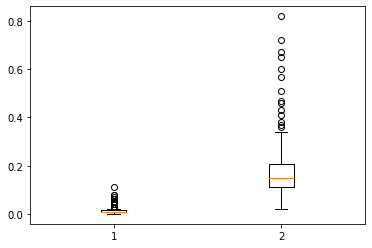

From left to right:
08-19-13-32-36-Policy-Reacher-Dense4WithTanh-L1
08-13-11-15-00-FixImageToEnv_TrainFreshPolicy-Reacher-Conv4Dense3-MSE


In [31]:
plottinghelpers.box_plot_across_runs(
    rootdir='runs/Policies',
    eval_folder_name='TestSet_Evaluations',
    error_index=4,
    metric_name='Goal Deviation',
    include=[
        '08-19-13-32-36-Policy-Reacher-Dense4WithTanh-L1',
        '08-13-11-15-00-FixImageToEnv_TrainFreshPolicy-Reacher-Conv4Dense3-MSE',
    ]
)

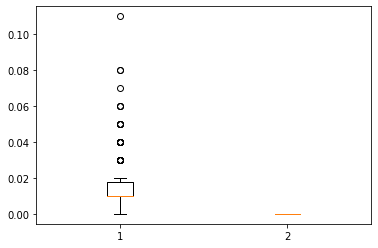

From left to right:
08-19-13-32-36-Policy-Reacher-Dense4WithTanh-L1



In [32]:
plottinghelpers.box_plot_across_runs(
    rootdir='runs/Policies',
    eval_folder_name='TestSet_Evaluations',
    error_index=4,
    metric_name='Goal Deviation',
    include=[
    '08-19-13-32-36-Policy-Reacher-Dense4WithTanh-L1',
    '08-14-08-54-19-FixImageEncoderPolicy_TrainDecoder-Reacher-Conv4Dense3-MSE',
    ]
)

In [12]:
img_pol = load_pretrained('Policies/08-19/08-19-20-24-49-FixImageEncoderPolicy_TrainDecoder-Reacher-Conv5Dense4-L1')
img_pol = img_pol.cpu()

In [16]:
traj = test_traj_data[0]

In [17]:
ip_data = simplereacheradapters.It_scaled_adapter(traj).float()
op_data = img_pol(ip_data)
print (ip_data.shape)
print (op_data.shape)
print (op_data)
print (simplereacheradapters.Ut_scaled_adapter_zero_center_reverse(op_data))
print (traj['states'][:, 6:])
print (F.l1_loss(traj['states'][:, 6:], simplereacheradapters.Ut_scaled_adapter_zero_center_reverse(op_data)))

torch.Size([25, 65536])
torch.Size([25, 3])
tensor([[-0.0185, -0.0049,  0.0049],
        [-0.0185, -0.0049,  0.0049],
        [-0.0185, -0.0049,  0.0049],
        [-0.0185, -0.0049,  0.0049],
        [-0.0185, -0.0049,  0.0049],
        [-0.0185, -0.0049,  0.0049],
        [-0.0185, -0.0049,  0.0049],
        [-0.0185, -0.0049,  0.0049],
        [-0.0185, -0.0049,  0.0049],
        [-0.0185, -0.0049,  0.0049],
        [-0.0185, -0.0049,  0.0049],
        [-0.0185, -0.0049,  0.0049],
        [-0.0185, -0.0049,  0.0049],
        [-0.0185, -0.0049,  0.0049],
        [-0.0185, -0.0049,  0.0049],
        [-0.0185, -0.0049,  0.0049],
        [-0.0185, -0.0049,  0.0049],
        [-0.0185, -0.0049,  0.0049],
        [-0.0185, -0.0049,  0.0049],
        [-0.0185, -0.0049,  0.0049],
        [-0.0185, -0.0049,  0.0049],
        [-0.0185, -0.0049,  0.0049],
        [-0.0185, -0.0049,  0.0049],
        [-0.0185, -0.0049,  0.0049],
        [-0.0185, -0.0049,  0.0049]], grad_fn=<TanhBackward>)
tensor

In [18]:
ld_pol = pretrain_policy.cpu()

In [19]:
ip_data = simplereacheradapters.XtYt_scaled_adapter(traj).float()
print (ip_data.shape)
op_data = ld_pol(ip_data)
print (op_data.shape)
print (op_data)
print (simplereacheradapters.Ut_scaled_adapter_zero_center_reverse(op_data))
print (traj['states'][:, 6:])
print (F.l1_loss(traj['states'][:, 6:], simplereacheradapters.Ut_scaled_adapter_zero_center_reverse(op_data)))

torch.Size([25, 6])
torch.Size([25, 3])
tensor([[ 0.1406, -0.4868,  0.1918],
        [ 0.1373, -0.4714,  0.2155],
        [ 0.1382, -0.4705,  0.2142],
        [ 0.1430, -0.4702,  0.2030],
        [ 0.1481, -0.4697,  0.1914],
        [ 0.1533, -0.4690,  0.1796],
        [ 0.1549, -0.4687,  0.1721],
        [ 0.1541, -0.4660,  0.1732],
        [ 0.1533, -0.4633,  0.1742],
        [ 0.1525, -0.4606,  0.1753],
        [ 0.1516, -0.4579,  0.1764],
        [ 0.1607, -0.4558,  0.1676],
        [ 0.1697, -0.4542,  0.1603],
        [ 0.1748, -0.4532,  0.1597],
        [ 0.1799, -0.4522,  0.1592],
        [ 0.1803, -0.4524,  0.1577],
        [ 0.1779, -0.4534,  0.1556],
        [ 0.1756, -0.4543,  0.1535],
        [ 0.1709, -0.4546,  0.1537],
        [ 0.1618, -0.4481,  0.1652],
        [ 0.1701, -0.4174,  0.1800],
        [ 0.1784, -0.3858,  0.1948],
        [ 0.1780, -0.3510,  0.2002],
        [ 0.1190, -0.2753,  0.1424],
        [ 0.0181, -0.0299,  0.0081]], grad_fn=<TanhBackward>)
tensor([[ 

In [27]:
traj_data = SimpleReacherTrajectoryDataset(root_folder, range(5000), device=cpu)
count = 0
max_dev = 0
for tId in range(len(traj_data)):
    last_row = traj_data[tId][states_key][-1, :]
    goal_dev_gt = F.l1_loss(last_row[:3], last_row[3:6])
    if goal_dev_gt > 0.01:
        # print (goal_dev_gt)
        max_dev = max(max_dev, goal_dev_gt)
        count += 1
print ('Total trajectories where there is goal deviation in ground truth : {}'.format(count))
print ('Maximum goal deviation in ground truth : {}'.format(max_dev))

Total trajectories where there is goal deviation in ground truth : 229
Maximum goal deviation in ground truth : 0.033625187543541234


In [18]:
expts = [
#   Image to Policy: Use pretrained image encoder, policy, train decoder/end-to-end 
#     [{
#         "expt_prefix":'Finetune_LowLR_FixImageEncoderTrigPolicy_TrainDecoder-Reacher-Conv5Dense4-L1',
#         "net_func": lambda: finetune_pretrained('Policies/08-19/08-19-20-24-49-FixImageEncoderPolicy_TrainDecoder-Reacher-Conv5Dense4-L1'),
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#         "optimizer_func": lambda net: optim.Adam(net.parameters(), lr=1e-4)
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'Finetune_RegularLR_FixImageEncoderTrigPolicy_TrainDecoder-Reacher-Conv5Dense4-L1',
#         "net_func": lambda: finetune_pretrained('Policies/08-19/08-19-20-24-49-FixImageEncoderPolicy_TrainDecoder-Reacher-Conv5Dense4-L1'),
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'Train_PretrainedImageEncoderAndPolicy_EndToEnd-Reacher-Conv4Dense3-L1',
#         "net_func": lambda: latent_policy_pretrained_img_enc_pol_train_end_to_end
#             (i_encoder=img_encoder_4_16_3, 
#              e_decoder=lambda: Dense([4096, 512, 6], last_act='sigmoid', prefix='envdec'),
#              policy=pretrain_policy
#             ),
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'Train_PretrainedImageEncoderAndAugmentedPolicy_EndToEnd-Reacher-Conv4Dense3-L1',
#         "net_func": lambda: latent_policy_pretrained_img_enc_pol_train_end_to_end
#             (i_encoder=img_encoder_4_16_3, 
#              e_decoder=lambda: Dense([4096, 512, 9], last_act='sigmoid', prefix='envdec'),
#              policy=pretrain_pol_augmented
#             ),
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'Train_PretrainedImageEncoderAndTrigPolicy_EndToEnd-Reacher-Conv4Dense3-L1',
#         "net_func": lambda: latent_policy_pretrained_img_enc_pol_train_end_to_end
#             (i_encoder=img_encoder_4_16_3, 
#              e_decoder=lambda: Dense([4096, 512, 12], last_act='sigmoid', prefix='envdec'),
#              policy=pretrain_pol_trig
#             ),
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],

#     [{
#         "expt_prefix":'FixImageEncoderPolicy_TrainDecoder-Reacher-Conv4Dense3-L1',
#         "net_func": lambda: latent_policy_fixed_img_enc_pol_train_env_dec
#             (i_encoder=img_encoder_4_16_3, 
#              e_decoder=lambda: Dense([4096, 512, 6], last_act='sigmoid', prefix='envdec'),
#              policy=pretrain_policy
#             ),
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'FixImageEncoderAugmentedPolicy_TrainDecoder-Reacher-Conv4Dense3-L1',
#         "net_func": lambda: latent_policy_fixed_img_enc_pol_train_env_dec
#             (i_encoder=img_encoder_4_16_3, 
#              e_decoder=lambda: Dense([4096, 512, 9], last_act='sigmoid', prefix='envdec'),
#              policy=pretrain_pol_augmented
#             ),
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'FixImageEncoderTrigPolicy_TrainDecoder-Reacher-Conv4Dense3-L1',
#         "net_func": lambda: latent_policy_fixed_img_enc_pol_train_env_dec
#             (i_encoder=img_encoder_4_16_3, 
#              e_decoder=lambda: Dense([4096, 512, 12], last_act='sigmoid', prefix='envdec'),
#              policy=pretrain_pol_trig
#             ),
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#   Train policy using fixed Image To Env function
#     [{
#         "expt_prefix":'FixImageToEnv_TrainFreshPolicy-Reacher-Conv4Dense3-MSE',
#         "net_func": lambda: latent_policy_from_latent(pretrain_img_to_env),
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": mse_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#   Image To Env function
#     [{
#         "expt_prefix":'ImageToEnv-Reacher-Conv4Dense3-MSE',
#         "net_func": lambda: image_to_env(img_encoder, env_decoder),
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.XtYt_scaled_adapter,
#         "loss_adapter_func": mse_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#   Policy
#     [{
#         "expt_prefix":'Policy-Reacher-Dense4WithTanh-L1',
#         "net_func": lambda: Dense(layer_dims=[6, 16, 16, 3], last_act='tanh', prefix='pol'),
#         "data_adapter_func": simplereacheradapters.XtYt_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'Policy_Augmented-Reacher-Dense4WithTanh-L1',
#         "net_func": lambda: Dense(layer_dims=[9, 16, 16, 3], last_act='tanh', prefix='pol'),
#         "data_adapter_func": simplereacheradapters.Xt_XtYt_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'Policy_TrigAugmented-Reacher-Dense4WithTanh-L1',
#         "net_func": lambda: Dense(layer_dims=[12, 16, 16, 3], last_act='tanh', prefix='pol'),
#         "data_adapter_func": simplereacheradapters.XtYt_trig_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#   Image to policy : Direct
#     [{
#         "expt_prefix":'ImageToPolicy-Reacher-ComposedAutoEncoder5Dense-L1',
#         "net_func": lambda: combined(img_encoder_5_32_5, lambda: Dense(layer_dims=[2048, 512, 128, 3], last_act='tanh', prefix='pol')), 
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'ImageToPolicy-Reacher-ComposedAutoEncoder5Dense-L1',
#         "net_func": lambda: combined(img_encoder_5_32_5, lambda: Dense(layer_dims=[2048, 512, 3], last_act='tanh', prefix='pol')), 
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'ImageToPolicy-Reacher-ImageEncoder4_16_3Dense3-L1',
#         "net_func": lambda: combined(img_encoder_4_16_3, lambda: Dense(layer_dims=[4096, 512, 3], last_act='tanh', prefix='pol')), 
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'ImageToPolicy-Reacher-ComposedAutoEncoder5Dense-L1',
#         "net_func": lambda: combined(img_encoder_5_32_7, lambda: Dense(layer_dims=[2048, 512, 3], last_act='tanh', prefix='pol')), 
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "data_to_label_adapter": simplereacheradapters.Ut_scaled_adapter_zero_center,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#   Image autoencoder
#     [{
#         "expt_prefix":'ImageAutoEncoder-Reacher-ComposedAutoEncoder4-MSE',
#         "net_func": img_auto_encoder,
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "loss_adapter_func": mse_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'ImageAutoEncoder-Reacher-ComposedAutoEncoder4-L1',
#         "net_func": img_auto_encoder_4_16_3,
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'ImageAutoEncoder-Reacher-ComposedAutoEncoder_5_16_7-L1',
#         "net_func": img_auto_encoder_5_16_7,
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'ImageAutoEncoder-Reacher-ComposedAutoEncoder_5_32_7-L1',
#         "net_func": img_auto_encoder_5_32_7,
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'ImageAutoEncoder-Reacher-ComposedAutoEncoder_5_16_5-L1',
#         "net_func": img_auto_encoder_5_16_5,
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
#     [{
#         "expt_prefix":'ImageAutoEncoder-Reacher-ComposedAutoEncoder_5_32_5-L1',
#         "net_func": img_auto_encoder_5_32_5,
#         "data_adapter_func": simplereacheradapters.It_scaled_adapter,
#         "loss_adapter_func": l1_loss_adapter,
#      },
#     {
#     },
#     {
#         "loss_adapter": l1_loss_adapter
#     }],
]